In [7]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
        
#     # 자산별 비중이 반영된 개별자산 누적 수익률
#     weightedCumulativeReturn = weight * cumulativeReturn
#     # 자산흐름 정규화: 시기별 각 자산 보유 비율
#     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
#     # 자산별 비중이 반영된 개별자산 일별 수익률
#     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
#     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
#     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
#     # 포트폴리오 누적 수익률
#     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
# #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    
    # 만약, weightDf에 모든 종목이 0으로 잡히는 구간이 있다면
    noWeight = weightDf.sum(axis=1) == 0
    if not weightDf.loc[noWeight].empty :
        # weightDf에 모든 종목이 0인 구간에서는 cash 컬럼을 추가하여 1로 설정한다.
        weightDf['cash'] = np.where(noWeight, 1, 0)
        # 첫 투자 비중은 현금을 제외한 동일비중
        firstWeight = [1/(len(weightDf.columns)-1)] * len(weightDf.columns)
        firstWeight[-1] = 0
        weightDf.iloc[0] =  firstWeight
        # closeDataSet에 cash컬럼을 추가하여 1로 설정한다.
        closeDataSet['cash'] = 1
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getAvgMomentum(closeDataSet, n=12):
    """
    평균 모멘텀 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 평균 모멘텀 df
    """
    n = 12
    avgMomentum = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1~n개월 모멘텀 합 계산
    for i in range(1, n+1): 
        avgMomentum = dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) + avgMomentum
        
    avgMomentum = pd.DataFrame(avgMomentum) # dataframe으로 변환
    avgMomentum = (avgMomentum / 12).fillna(0) # 평균화
    return avgMomentum

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=dataSetOnRebalancingDate.index, columns=dataSetOnRebalancingDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / 12 # 평균화
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0) # 모멘텀 스코어에 따른 weight 계산
    return weight, avgMomentumScore

In [9]:
# 데이터 로드
kodex200 = getCloseData("069500", "2002") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2002") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)

closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,21792,49960.0
2012-01-25,21868,49960.0
2012-01-26,21889,49930.0
2012-01-27,21923,50000.0
2012-01-30,21675,50130.0
...,...,...
2022-06-15,32285,61265.0
2022-06-16,32265,61355.0
2022-06-17,32025,61255.0


## 1. 실제 주식 매매 단위 고려

In [10]:
# 일별 수익률
dayReturn = (closeDataSet / closeDataSet.shift(1)).fillna(1)

# 누적 수익률
cumReturn = closeDataSet / closeDataSet.iloc[0]

# 리밸런싱 날짜
rebalancingDate = getRebalancingDate(closeDataSet)

# 리밸런싱 비율, 동일비중으로 가정
portfolioWeight = [0.5, 0.5]
targetWeight = pd.DataFrame([portfolioWeight] * len(rebalancingDate), index=rebalancingDate, columns=closeDataSet.columns) 
targetWeight

,kodex200,kodex10Bond
Date,,
2012-01-31,0.5,0.5
2012-02-29,0.5,0.5
2012-03-30,0.5,0.5
2012-04-30,0.5,0.5
2012-05-31,0.5,0.5
...,...,...
2022-02-28,0.5,0.5
2022-03-31,0.5,0.5
2022-04-29,0.5,0.5


In [11]:
cash = 10000000 # 초기 자본금, 1000만원 가정
prevQuantity = 0 # 초기 자산 보유량

totalAssetFlow = []
start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일


for end in rebalancingDate[1:]:
    weight = targetWeight.loc[start] # 당기 리밸런싱 비율
    
    capacity = cash * weight # 리밸런싱 비율에 따른 자산별 사용 가능 현금
    
    priceData = closeDataSet.loc[start: end] # 당기 가격 데이터
    
    quantity = capacity // priceData.iloc[0] # capacity에 따라 실제 매수할 수 있는 주식수
    diffQuantity = quantity - prevQuantity # 실제 매매해야하는 수량, 양수-> 매수, 음수 -> 매도
    fee = abs(diffQuantity) *  priceData.iloc[0] * 0.0015 # 수수료, 0.15% => 0.0015
    
    left = (capacity - quantity * priceData.iloc[0]).sum() # 잔여 현금
#     print(left)
    
    assetFlow = quantity * priceData # 자산 흐름
    totalAssetFlow.append(assetFlow)
    
    cash = (assetFlow.iloc[-1].sum() + left) - fee # cash 업데이트,,
    prevQuantity = quantity # 이전 자산 보유량 업데이트
    start = end # 리밸런싱 날짜 업데이트
    
# totalAssetFlow

In [12]:
totalAssetFlow = pd.concat(totalAssetFlow)
# 매달 마지막 영업일엔 리밸런싱이 들어간 row만 남긴다.
totalAssetFlow = totalAssetFlow.loc[~totalAssetFlow.index.duplicated(keep='last')]
totalAssetFlow['portfolio'] = totalAssetFlow.sum(axis=1)
totalAssetFlow

,kodex200,kodex10Bond,portfolio
Date,,,
2012-01-31,4990368.0,4967820.0,9958188.0
2012-02-01,4996551.0,4972770.0,9969321.0
2012-02-02,5052656.0,4967820.0,10020476.0
2012-02-03,5027008.0,4968810.0,9995818.0
2012-02-06,5034336.0,4961880.0,9996216.0
...,...,...,...
2022-06-15,6715280.0,7045475.0,13760755.0
2022-06-16,6711120.0,7055825.0,13766945.0
2022-06-17,6661200.0,7044325.0,13705525.0


In [13]:
totalAssetFlow['portfolio'] / totalAssetFlow['portfolio'].iloc[0]

Date
2012-01-31    1.000000
2012-02-01    1.001118
2012-02-02    1.006255
2012-02-03    1.003779
2012-02-06    1.003819
                ...   
2022-06-15    1.381853
2022-06-16    1.382475
2022-06-17    1.376307
2022-06-20    1.366878
2022-06-21    1.374186
Name: portfolio, Length: 2558, dtype: float64

In [14]:
getEvaluation(totalAssetFlow['portfolio'] / totalAssetFlow['portfolio'].iloc[0])

cagr: 1.03180941919061
mdd: 19.87604348073061


(1.03180941919061,
 Date
 2012-01-31     0.000000
 2012-02-01     0.000000
 2012-02-02     0.000000
 2012-02-03     0.246076
 2012-02-06     0.242104
                 ...    
 2022-06-15    18.998229
 2022-06-16    18.961792
 2022-06-17    19.323337
 2022-06-20    19.876043
 2022-06-21    19.447658
 Name: portfolio, Length: 2558, dtype: float64,
 19.87604348073061)

## 2. 리밸런싱 기준 일자와 실제 투자 시작 일자

지금까지 리밸런싱 기준일은 매달 말일이었습니다.  
실제 전략대로 투자하고 싶다면 어떤 날이던 리밸런싱 비율에 맞춰서 들어가면 될까요?  
**아닙니다.**  
매달 말일을 기준으로 했기 때문에, 말일을 기준으로 한 자산 흐름에 맞춰서 들어가야합니다.

In [ ]:
# 데이터 로드
kodex200 = getCloseData("069500", "2002") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2002") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
# closeDataSet = pd.merge(kodex200, kodex10Bond, left_index= True , right_index= True)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
# closeDataSet['kodex10Bond'] = 1
closeDataSet.dropna(inplace=True)
rebalancingDate = getRebalancingDate(closeDataSet)
closeDataSet = closeDataSet.loc[rebalancingDate[0]:]
closeDataSet

In [61]:
weight= pd.DataFrame([[0.6, 0.4]] * len(closeDataSet), index=closeDataSet.index, columns=closeDataSet.columns) 
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet)

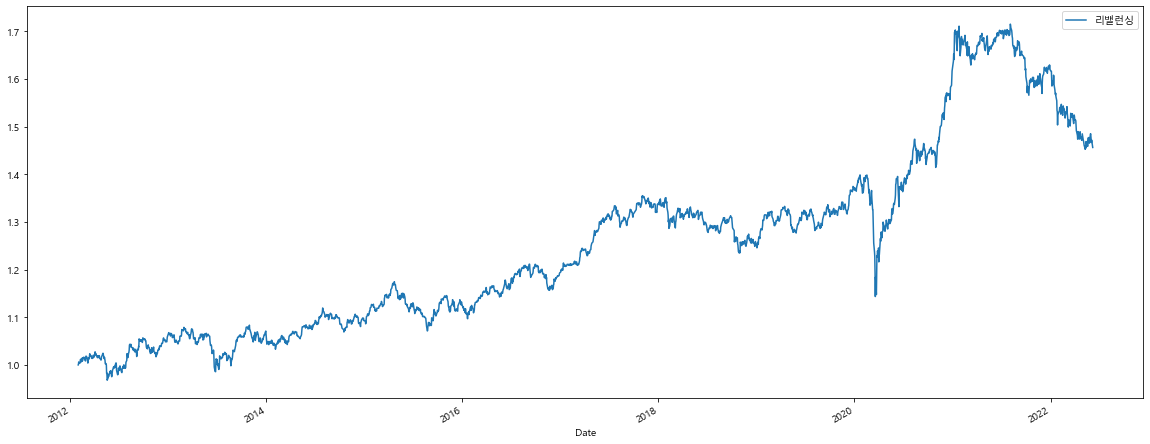

In [62]:
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(20,8))
rebalPortfolioCumulativeReturn.plot(label="리밸런싱")
plt.legend()
plt.show()